In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
file = "Raotbl6.csv"
macro_data = pd.read_csv(file, parse_dates=['date'], index_col = 'date')
macro_data.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


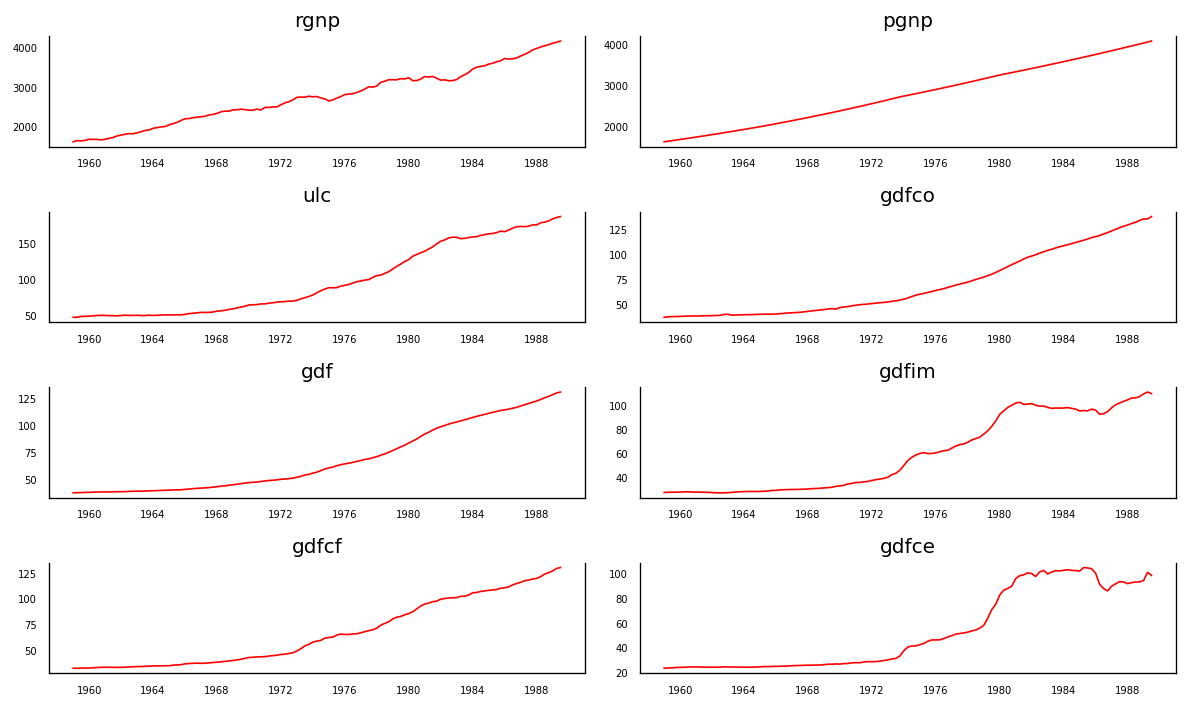

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [7]:
ad_fuller_result_1 = adfuller(macro_data['rgnp'].diff()[1:])
print(ad_fuller_result_1[0:2])
ad_fuller_result_2 = adfuller(macro_data['ulc'].diff()[1:])
print(ad_fuller_result_2[0:2])

(-5.427594381007333, 2.9633019848469254e-06)
(-3.576080473150909, 0.0062351318302382155)


In [8]:
granger_1 = grangercausalitytests(macro_data[['ulc', 'rgnp']], 4)
granger_2 = grangercausalitytests(macro_data[['rgnp','ulc']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=22.9444 , p=0.0000  , df=1
likelihood ratio test: chi2=21.0242 , p=0.0000  , df=1
parameter F test:         F=22.3802 , p=0.0000  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=16.1029 , p=0.0003  , df=2
likelihood ratio test: chi2=15.1179 , p=0.0005  , df=2
parameter F test:         F=7.7188  , p=0.0007  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=23.9675 , p=0.0000  , df=3
likelihood ratio test: chi2=21.8515 , p=0.0001  , df=3
parameter F test:         F=7.5231  , p=0.0001  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.3018  , p=0.0000  

In [9]:
macro_data = macro_data[['ulc', 'rgnp']]
macro_data.shape

(123, 2)

In [10]:
train_df = macro_data[:-12]
test_df = macro_data[-12:]

In [11]:
print(test_df.shape)

(12, 2)


In [12]:
model = VAR(train_df.diff()[1:])
model

In [13]:
sorted_order = model.select_order(maxlags=20)
sorted_order.summary()

,AIC,BIC,FPE,HQIC
0,6.778,6.834,878.3,6.800
1,5.988,6.154*,398.5,6.055
2,5.942,6.220,380.9,6.054
3,5.933,6.322,377.4,6.090
4,5.793*,6.293,328.5*,5.995*
5,5.873,6.484,356.3,6.120
6,5.828,6.550,341.1,6.119
7,5.894,6.727,365.0,6.230
8,5.890,6.835,364.8,6.271
9,5.942,6.998,385.8,6.368


In [14]:
var_model = VARMAX(train_df, order=(4,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['ulc', 'rgnp']   No. Observations:                  111
Model:                         VAR(4)   Log Likelihood              -11864.862
                          + intercept   AIC                          23771.725
Date:                Mon, 12 Feb 2024   BIC                          23828.625
Time:                        15:47:24   HQIC                         23794.807
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          34.01, 106.01   Jarque-Bera (JB):         22.51, 13.87
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.27, 0.27   Skew:                      0.73, -0.86
Prob(H) (two-sided):            0.47,

In [21]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df), end=len(train_df)+n_forecast-1)
predictions = predict.predicted_mean

In [22]:
predictions.columns = ['ulc_predicted', 'rgnp_predicted']
predictions

,ulc_predicted,rgnp_predicted
1986-10-01,166.160652,3571.618950
1987-01-01,241.388295,3753.524741
1987-04-01,54.257405,3558.805821
1987-07-01,263.433678,3855.590102
1987-10-01,148.642694,3485.951788
1988-01-01,172.271049,3765.757125
1988-04-01,152.981415,3630.931969
1988-07-01,208.555637,3732.917751
1988-10-01,143.724118,3566.696542
1989-01-01,196.731073,3766.568500


In [23]:
test_vs_pred = pd.concat([test_df, predictions],axis=1)

<Axes: >

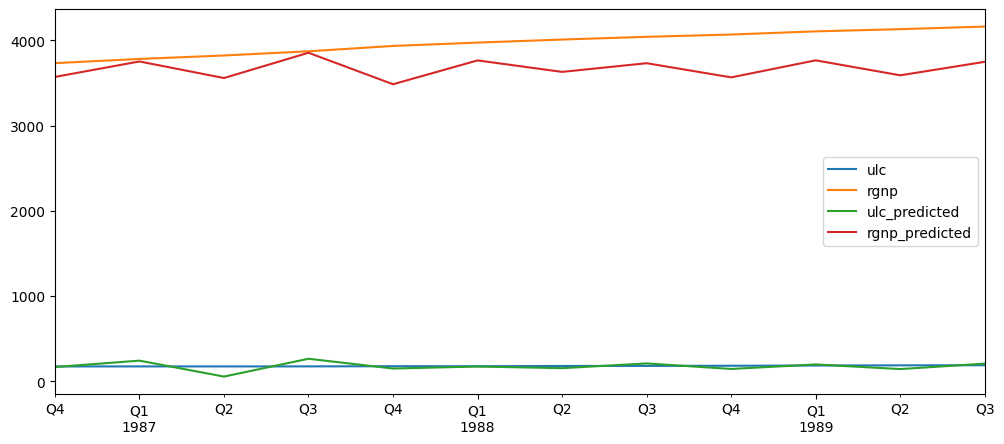

In [24]:
test_vs_pred.plot(figsize=(12,5))

In [29]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['ulc_predicted'], test_df['ulc']))
print('ulc ', rmse_ulc)
rmse_rgnp=math.sqrt(mean_squared_error(predictions['rgnp_predicted'], test_df['rgnp']))
print('rgnp ', rmse_rgnp)

ulc  52.39658836279932
rgnp  343.55906599664934
